# Transformers

## References

* https://arxiv.org/abs/1706.03762 (Attention is all you need)
* https://www.youtube.com/watch?v=eMlx5fFNoYc (3Blue1Brown)
* https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html (Sebastian Raschka)


## Architecture

![transformers](./images/Arch_Transformers.png)

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

## Embedding

* Creating dummy encodings here to replicate the effect of any embedding model.
* We can pick any pretrained embedding model (word2vec, bert etc.) to get word vectors.
* Idea is to get vector representation of each word with comparable information in a mathematical plane.



### Tokenization

Sentence - `I am new to NLP with Deep Learning.`

Convinient Lie - `I|am|new|to|NLP|with|Deep|Learning|.`

Actual Truth - `I |am |new to| NLP |with |Deep |Learn|ing.`

In [3]:
paragraph = """I am new to NLP with deep learning. I like Deep Learning and I like NLP. I am trying to combine it."""

conversion = """Je suis nouveau en PNL avec l'apprentissage profond. J'aime le Deep Learning et j'aime la PNL. J'essaie de le combiner."""

bow = paragraph.lower().replace(".", "").split(" ") + \
    conversion.lower().replace(".", "").split(" ")

vocab = set(bow)

In [4]:
tokenizer = {val: idx for idx, val in enumerate(vocab)}

In [5]:
def sentence_separator(sentence):
    return sentence.lower().replace(".", "").split(" ")


def get_tokens(sentence):
    sentence_sep = sentence_separator(sentence)
    tokens = torch.Tensor([tokenizer[i] for i in sentence_sep]).type(torch.int32)
    return tokens


def get_embedding(tokens, dim=30):
    torch.manual_seed(123)
    embed = torch.nn.Embedding(len(vocab), dim)
    embedded_sentence = embed(tokens).detach()
    return embedded_sentence

In [6]:
sentence = "I like NLP"
tokens = get_tokens(sentence)
tokens

tensor([25, 26,  4], dtype=torch.int32)

In [7]:
get_embedding(tokens, dim=10)

tensor([[-0.5399,  1.2117, -0.8632,  1.3337,  0.0771, -0.0522,  0.2386,  0.1411,
         -1.3354, -2.9340],
        [ 0.1141, -1.2072, -0.3008,  0.1427,  1.7250, -0.0934,  2.7436, -0.2764,
          0.9638, -1.8719],
        [ 0.8805,  1.5542,  0.6266, -0.1755,  0.0983, -0.0935,  0.2662, -0.5850,
          0.8768,  1.6221]])

## Positional Encoding

\begin{align*}
PE(pos, 2i) &= \sin(\frac{pos}{10000^{\frac{2i}{d_{model}}}}) \\ \\
PE(pos, 2i + 1) &= \cos(\frac{pos}{10000^{\frac{2i}{d_{model}}}})
\end{align*}

* Single value of $i \in [0, d_{model})$ map both sine and cosine function
* values will reside in -1 and 1
* 10000 is a scaling value

In [246]:
def positional_encoding(n_tokens, d_model, scale=10_000):
    """
    * Rows - Positions (sentence length, number of tokens in input sentence)
    * Columns - Dimensions (Dimensions of embedding or models)
    """
    p = torch.zeros((n_tokens, d_model))
    positions = torch.arange(n_tokens)
    for i in range(int(d_model / 2)):
        denominator = math.pow(scale, (2 * i) / d_model)
        p[positions, 2 * i] = torch.sin(positions / denominator)
        p[positions, (2 * i) + 1] = torch.cos(positions / denominator)
    return p

positional_encoding(5, 5)

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [ 0.8415,  0.5403,  0.0251,  0.9997,  0.0000],
        [ 0.9093, -0.4161,  0.0502,  0.9987,  0.0000],
        [ 0.1411, -0.9900,  0.0753,  0.9972,  0.0000],
        [-0.7568, -0.6536,  0.1003,  0.9950,  0.0000]])

In [292]:
def positional_encoding_opt(n_tokens, d_model, scale=10_000):
    """
    * Rows - Positions (sentence length, number of tokens in input sentence)
    * Columns - Dimensions (Dimensions of embedding or models)
    """
    p = torch.zeros((n_tokens, d_model))
    positions = torch.arange(n_tokens).unsqueeze(1)
    denominator = 1 / torch.pow(scale, torch.arange(0, d_model, 2).unsqueeze(0) / d_model)
    if d_model % 2 == 0:
        end_idx = denominator.shape[1]
    else:
        end_idx = denominator.shape[1] - 1

    p[:, 0::2] = torch.sin(positions * denominator)
    p[:, 1::2] = torch.cos(positions * denominator[:, :end_idx])
    return p


positional_encoding_opt(5, 5)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  2.5116e-02,  9.9968e-01,  6.3096e-04],
        [ 9.0930e-01, -4.1615e-01,  5.0217e-02,  9.9874e-01,  1.2619e-03],
        [ 1.4112e-01, -9.8999e-01,  7.5285e-02,  9.9716e-01,  1.8929e-03],
        [-7.5680e-01, -6.5364e-01,  1.0031e-01,  9.9496e-01,  2.5238e-03]])

In [250]:
pd.DataFrame(
    positional_encoding_opt(4, 4, 100),
    columns=[f"dim {i}" for i in range(4)],
    index=[f"pos {i}" for i in range(4)],
)

,dim 0,dim 1,dim 2,dim 3
pos 0,0.000000,1.000000,0.000000,1.000000
pos 1,0.841471,0.540302,0.099833,0.995004
pos 2,0.909297,-0.416147,0.198669,0.980067
pos 3,0.141120,-0.989992,0.295520,0.955337


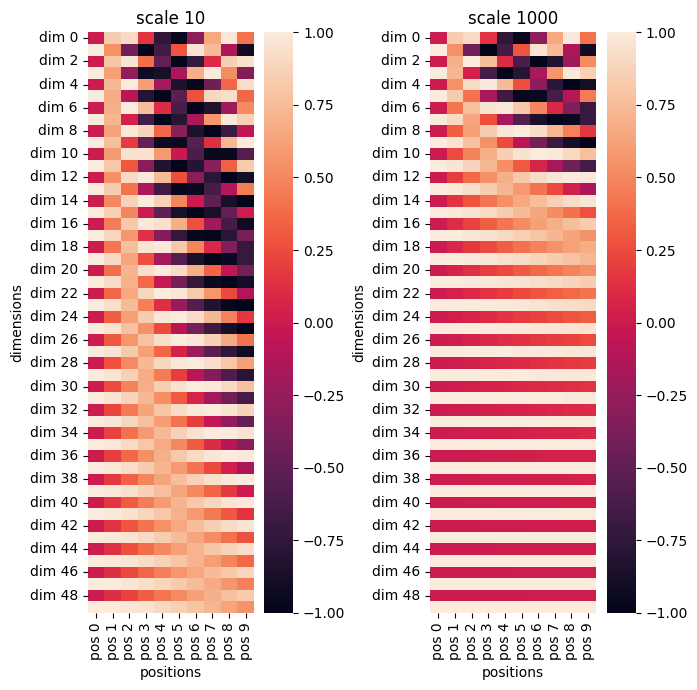

In [251]:
d_model = 50
n_tokens = 10


fig, ax = plt.subplots(1, 2, figsize=(7, 7))
pe = positional_encoding_opt(d_model=d_model, n_tokens=n_tokens, scale=10)
sns.heatmap(
    pd.DataFrame(
        pe,
        columns=[f"dim {i}" for i in range(d_model)],
        index=[f"pos {i}" for i in range(n_tokens)],
    ).T,
    vmin=-1,
    vmax=1,
    ax=ax[0],
)
ax[0].set_title("scale 10")
ax[0].set_ylabel("dimensions")
ax[0].set_xlabel("positions")

pe = positional_encoding_opt(d_model=d_model, n_tokens=n_tokens, scale=1000)
sns.heatmap(
    pd.DataFrame(
        pe,
        columns=[f"dim {i}" for i in range(d_model)],
        index=[f"pos {i}" for i in range(n_tokens)],
    ).T,
    vmin=-1,
    vmax=1,
    ax=ax[1],
)
ax[1].set_title("scale 1000")
ax[1].set_ylabel("dimensions")
ax[1].set_xlabel("positions")

plt.tight_layout()
plt.show()

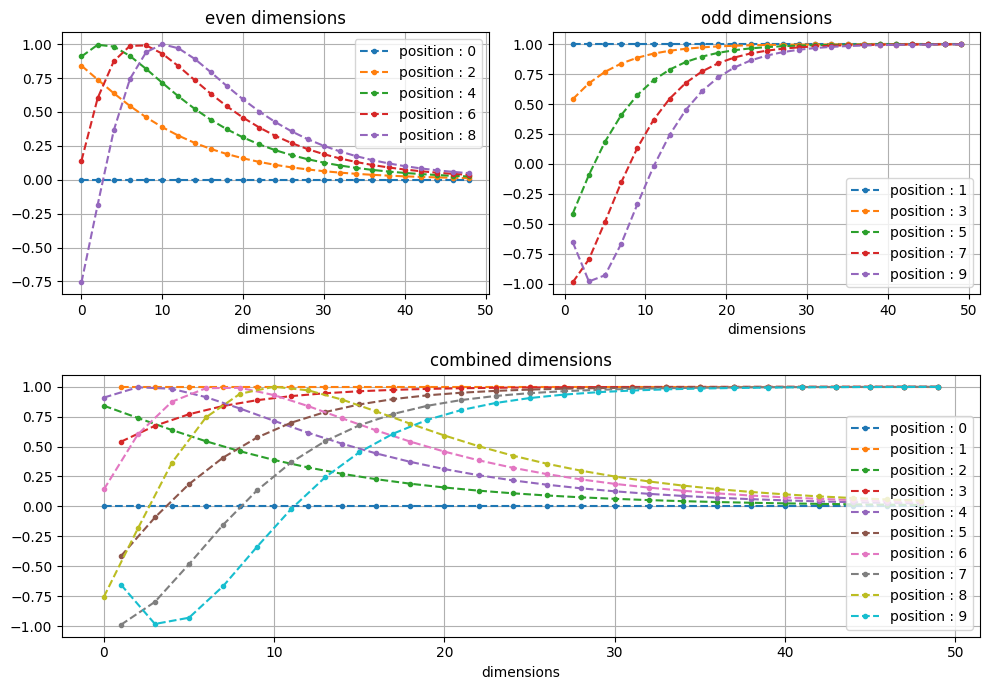

In [252]:
d_model = 50
n_tokens = 5
pe = positional_encoding_opt(d_model=d_model, n_tokens=n_tokens, scale=100)

fig = plt.figure(figsize=(10, 7))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, (3, 4))
for i in range(n_tokens):
    ax1.plot(np.arange(0, d_model, 2), pe[i, 0::2], ".--", label=f"position : {2 * i}")
    ax2.plot(
        np.arange(1, d_model, 2), pe[i, 1::2], ".--", label=f"position : {2*i + 1}"
    )

for i in range(n_tokens):
    ax3.plot(np.arange(0, d_model, 2), pe[i, 0::2], ".--", label=f"position : {2 * i}")
    ax3.plot(
        np.arange(1, d_model, 2), pe[i, 1::2], ".--", label=f"position : {2*i + 1}"
    )

ax1.legend()
ax1.grid()
ax1.set_title("even dimensions")
ax1.set_xlabel("dimensions")

ax2.legend()
ax2.grid()
ax2.set_title("odd dimensions")
ax2.set_xlabel("dimensions")

ax3.legend(loc="best")
ax3.grid()
ax3.set_title("combined dimensions")
ax3.set_xlabel("dimensions")

plt.tight_layout()
plt.show()

## Embedding + Positional Encoding

In [254]:
# sentence = "I am new to NLP with deep learning."
sentence = paragraph
tokens = get_tokens(sentence)

In [255]:
n_tokens = len(tokens)
d_model = 10

pe = positional_encoding_opt(n_tokens=n_tokens, d_model=d_model, scale=100)
df = pd.DataFrame(
    pe,
    columns=[f"dim {i}" for i in range(pe.shape[1])],
    index=[f"pos {i}" for i in range(pe.shape[0])],
)
df.insert(0, column="token", value=tokens)
df.insert(0, column="word", value=sentence_separator(sentence))
df

,word,token,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,25,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
pos 1,am,12,0.841471,0.540302,0.387674,0.921796,0.157827,0.987467,0.063054,0.998010,0.025116,0.999685
pos 2,new,3,0.909297,-0.416147,0.714713,0.699417,0.311697,0.950181,0.125857,0.992048,0.050217,0.998738
pos 3,to,19,0.141120,-0.989992,0.929966,0.367644,0.457755,0.889079,0.188159,0.982139,0.075285,0.997162
pos 4,nlp,4,-0.756802,-0.653644,0.999766,-0.021631,0.592338,0.805690,0.249712,0.968320,0.100306,0.994957
pos 5,with,24,-0.958924,0.283662,0.913195,-0.407523,0.712073,0.702105,0.310272,0.950648,0.125264,0.992123
pos 6,deep,22,-0.279415,0.960170,0.683794,-0.729675,0.813960,0.580922,0.369596,0.929192,0.150143,0.988664
pos 7,learning,9,0.656987,0.753902,0.347443,-0.937701,0.895443,0.445176,0.427450,0.904039,0.174927,0.984581
pos 8,i,25,0.989358,-0.145500,-0.043251,-0.999064,0.954481,0.298272,0.483602,0.875288,0.199601,0.979877
pos 9,like,26,0.412118,-0.911130,-0.427180,-0.904167,0.989594,0.143891,0.537830,0.843053,0.224149,0.974555


In [256]:
embeddings = get_embedding(tokens, dim=d_model)

In [257]:
df = pd.DataFrame(
    embeddings,
    columns=[f"dim {i}" for i in range(embeddings.shape[1])],
    index=[f"pos {i}" for i in range(embeddings.shape[0])],
)
df.insert(0, column="token", value=tokens)
df.insert(0, column="word", value=sentence_separator(sentence))
df

,word,token,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,25,-0.539865,1.211683,-0.863213,1.333719,0.077101,-0.052181,0.238623,0.141060,-1.335449,-2.934045
pos 1,am,12,1.396584,-0.994911,-0.001582,1.247089,-0.077105,1.277377,-1.459629,-2.159528,-0.258219,-2.040734
pos 2,new,3,-0.631505,-2.839994,-1.324957,0.178428,-2.133753,1.052358,-0.388483,-0.934346,-0.499144,-1.086653
pos 3,to,19,0.836472,0.028520,-0.979686,-2.112629,-0.272145,-0.350998,1.115163,-0.617218,-2.270833,-1.381871
pos 4,nlp,4,0.880544,1.554159,0.626616,-0.175487,0.098284,-0.093507,0.266215,-0.585036,0.876837,1.622144
pos 5,with,24,1.311315,-0.035963,0.211814,-0.008625,1.857613,2.132067,-0.505607,-0.798839,-1.094393,-1.019690
pos 6,deep,22,0.900836,0.483984,-1.323729,0.786925,1.381754,-0.069367,-0.761166,0.241627,-0.587812,-1.150584
pos 7,learning,9,0.903148,-0.721844,-0.595084,-0.711218,0.622965,-1.372882,-2.214989,-1.319310,-2.091499,0.962852
pos 8,i,25,-0.539865,1.211683,-0.863213,1.333719,0.077101,-0.052181,0.238623,0.141060,-1.335449,-2.934045
pos 9,like,26,0.114110,-1.207227,-0.300826,0.142741,1.725049,-0.093351,2.743574,-0.276385,0.963811,-1.871931


In [258]:
combined_emb = pe + embeddings
combined_emb

df = pd.DataFrame(
    combined_emb,
    columns=[f"dim {i}" for i in range(combined_emb.shape[1])],
    index=[f"pos {i}" for i in range(combined_emb.shape[0])],
)
df.insert(0, column="token", value=tokens)
df.insert(0, column="word", value=sentence_separator(sentence))
df

,word,token,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,25,-0.539865,2.211683,-0.863213,2.333719,0.077101,0.947819,0.238623,1.141060,-1.335449,-1.934045
pos 1,am,12,2.238055,-0.454608,0.386092,2.168885,0.080722,2.264843,-1.396576,-1.161518,-0.233102,-1.041049
pos 2,new,3,0.277792,-3.256141,-0.610244,0.877846,-1.822056,2.002539,-0.262626,0.057703,-0.448928,-0.087914
pos 3,to,19,0.977592,-0.961473,-0.049720,-1.744985,0.185610,0.538081,1.303322,0.364920,-2.195548,-0.384709
pos 4,nlp,4,0.123742,0.900515,1.626382,-0.197118,0.690621,0.712182,0.515927,0.383285,0.977144,2.617100
pos 5,with,24,0.352391,0.247699,1.125009,-0.416147,2.569686,2.834172,-0.195336,0.151809,-0.969129,-0.027567
pos 6,deep,22,0.621421,1.444155,-0.639935,0.057250,2.195714,0.511554,-0.391569,1.170819,-0.437668,-0.161920
pos 7,learning,9,1.560135,0.032058,-0.247642,-1.648919,1.518408,-0.927706,-1.787539,-0.415271,-1.916572,1.947433
pos 8,i,25,0.449494,1.066183,-0.906464,0.334655,1.031582,0.246091,0.722225,1.016348,-1.135848,-1.954168
pos 9,like,26,0.526228,-2.118357,-0.728006,-0.761425,2.714643,0.050541,3.281404,0.566668,1.187960,-0.897376


## Attention (SingleHead)

![scaled-dot-product-attention](./images/Arch_ScaledDotProductAttention.png)

\begin{align*}
\text{Attention}(Q, K, V) &= \text{softmax}\big( \frac{Q K^T}{\sqrt{d_k}} \big)V \\ \\
Q &= W_Q. X  & q_i &= W_Q x_i \text{ where } i \in [1, T] \\ 
K &= W_K. X  & k_i &= W_K x_i \text{ where } i \in [1, T] \\ 
V &= W_V. X  & v_i &= W_V x_i \text{ where } i \in [1, T] \\ \\
\text{where } T &= \text{Number of tokens in the sentence}
\end{align*}

* 2 sentences 
    * I want this to be a fair game
    * I want to go to a fair
* In these sentences word `fair` has two meanings that changes with rest of the context.

    
    || I | want | this | to | be | a | fair | game |
    |-|-|-|-|-|-|-|-|-|
    | I |||||||||
    | want |||||||||
    | this |||||||||
    | to |||||||||
    | be |||||||||
    | a |||||||||
    | fair |||||||X|X|
    | game |||||||X||


In [260]:
def softmax(x):
    if len(x.shape) == 1:
        x = x.view(1, -1)
    return x / torch.sum(x, axis=1).view(-1, 1)


softmax(torch.Tensor([1, 1, 1, 1])), softmax(torch.Tensor([[1, 1, 1, 1], [1, 2, 1, 4]]))

(tensor([[0.2500, 0.2500, 0.2500, 0.2500]]),
 tensor([[0.2500, 0.2500, 0.2500, 0.2500],
         [0.1250, 0.2500, 0.1250, 0.5000]]))

In [261]:
d_model = 30

sentence = "I am new to NLP with deep learning"

tokens = get_tokens(sentence)
X = get_embedding(tokens, dim=d_model)

In [262]:
d_query, d_key, d_value = 24, 24, 28

W_Q = torch.rand(d_query, d_model)
W_K = torch.rand(d_key, d_model)
W_V = torch.rand(d_value, d_model)

In [263]:
Q = torch.matmul(X, W_Q.T)
K = torch.matmul(X, W_K.T)
V = torch.matmul(X, W_V.T)

Q.shape, K.shape, V.shape

(torch.Size([8, 24]), torch.Size([8, 24]), torch.Size([8, 28]))

In [264]:
omega = softmax((Q @ K.T) / np.sqrt(d_key))

pd.DataFrame(
    omega,
    columns=sentence_separator(sentence),
    index=sentence_separator(sentence),
)

,i,am,new,to,nlp,with,deep,learning
i,-0.044762,0.568900,0.386138,-0.055835,0.358592,-0.389768,-0.187438,0.364173
am,-0.101277,0.685891,0.415610,-0.106656,0.401726,-0.424653,-0.257003,0.386362
new,-0.108570,0.716416,0.409127,-0.102575,0.413380,-0.455819,-0.273351,0.401392
to,-0.079665,1.061903,0.233725,-0.276019,0.357092,-0.275939,-0.500777,0.479679
nlp,-0.097255,0.713212,0.427547,-0.136364,0.395224,-0.434725,-0.246654,0.379015
with,-0.105554,0.698945,0.414142,-0.120625,0.401866,-0.416816,-0.250849,0.378890
deep,-0.062033,0.637639,0.409868,-0.126739,0.413370,-0.434938,-0.239759,0.402593
learning,-0.093402,0.701427,0.403921,-0.135215,0.420561,-0.424558,-0.279384,0.406650


In [265]:
def attention(Q, K, V, d_key):
    return softmax((Q @ K.T) / np.sqrt(d_key)) @ V

In [266]:
attn_out = attention(Q, K, V, d_key)

attn_out.shape

torch.Size([8, 28])

In [267]:
df = pd.DataFrame(
    attn_out,
    columns=[f"dim {i}" for i in range(attn_out.shape[1])],
    index=sentence_separator(sentence),
)
df

,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9,...,dim 18,dim 19,dim 20,dim 21,dim 22,dim 23,dim 24,dim 25,dim 26,dim 27
i,-9.091824,-9.095536,-7.767350,-7.922789,-9.544976,-12.542538,-10.034842,-9.639094,-6.381557,-9.031127,...,-10.597717,-5.972363,-12.366668,-11.448648,-11.609331,-5.862499,-12.208331,-10.172973,-8.280852,-11.060220
am,-10.462186,-10.475421,-8.852249,-9.427150,-11.152580,-14.253040,-11.394776,-11.238196,-7.263732,-10.483558,...,-12.214256,-6.995421,-14.212783,-13.090892,-13.232929,-6.871883,-14.004647,-11.645556,-9.287460,-12.633591
new,-10.888549,-10.835136,-9.162340,-9.812609,-11.601485,-14.710410,-11.847306,-11.672871,-7.509264,-10.888959,...,-12.677314,-7.279572,-14.713865,-13.554757,-13.667402,-7.205338,-14.521189,-12.019416,-9.615485,-13.110913
to,-11.885971,-12.543069,-9.969396,-12.284824,-13.663627,-15.082450,-13.182585,-13.072351,-8.660020,-12.885329,...,-14.046373,-8.001851,-16.645714,-15.443998,-15.077682,-9.262239,-16.130341,-13.711301,-10.735078,-15.177872
nlp,-10.582744,-10.657916,-9.017707,-9.564417,-11.395362,-14.560806,-11.420550,-11.541686,-7.287823,-10.632662,...,-12.362752,-7.168604,-14.555548,-13.331668,-13.514054,-7.020373,-14.200608,-11.862644,-9.370336,-12.939515
with,-10.463023,-10.525402,-8.857405,-9.462024,-11.196281,-14.291339,-11.347799,-11.322687,-7.245550,-10.515345,...,-12.217028,-7.040567,-14.284988,-13.116700,-13.272263,-6.903189,-14.024603,-11.659470,-9.255206,-12.688600
deep,-10.225756,-10.339153,-8.889226,-9.055676,-10.833356,-13.919945,-11.236163,-10.975959,-7.118090,-10.287728,...,-11.910110,-6.816338,-13.953539,-12.929621,-13.113915,-6.935207,-13.743979,-11.443378,-9.067595,-12.520720
learning,-10.700145,-10.809072,-9.152103,-9.701159,-11.427388,-14.425274,-11.714851,-11.501400,-7.458038,-10.823068,...,-12.482615,-7.152184,-14.554391,-13.456051,-13.581158,-7.255484,-14.352341,-11.930498,-9.442053,-13.009768


## Embedding + Positional Encoding + Attention

In [276]:
n_tokens = len(tokens)
d_model = 10

sentence = "I like NLP with deep learning."

tokens = get_tokens(sentence)
embeddings = get_embedding(tokens, dim=d_model)

In [277]:
pe = positional_encoding_opt(n_tokens=n_tokens, d_model=d_model, scale=100)

d_query, d_key, d_value = 10, 10, 10

W_Q = torch.rand(d_query, d_model)
W_K = torch.rand(d_key, d_model)
W_V = torch.rand(d_value, d_model)

In [279]:
combined_emb = pe + embeddings

In [280]:
Q = torch.matmul(combined_emb, W_Q.T)
K = torch.matmul(combined_emb, W_K.T)
V = torch.matmul(combined_emb, W_V.T)


attn_out = attention(Q, K, V, d_key)

df = pd.DataFrame(
    attn_out,
    columns=[f"dim {i}" for i in range(attn_out.shape[1])],
    index=[f"pos {i}" for i in range(attn_out.shape[0])],
)
df.insert(
    loc=0,
    column="word",
    value=sentence_separator(sentence),
)
df

,word,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,3.994382,4.052099,2.941273,5.270782,5.997838,4.377283,3.939869,4.796157,3.451249,2.809921
pos 1,like,4.030851,4.091831,2.947578,5.340122,6.053899,4.419761,3.970452,4.827797,3.478238,2.825324
pos 2,nlp,4.036146,4.111368,2.991500,5.375597,6.090721,4.474705,3.993887,4.859150,3.518182,2.833853
pos 3,with,4.002381,4.071481,2.974983,5.357818,6.060258,4.462673,3.969268,4.815951,3.505456,2.796729
pos 4,deep,4.042880,4.111853,2.986598,5.369304,6.086847,4.462160,4.002083,4.868002,3.518187,2.836144
pos 5,learning,3.997452,4.020534,2.814725,5.235060,5.936326,4.263834,3.884663,4.713002,3.355605,2.783971


## MultiHead Attention

![multi-head-attention](./images/Arch_MultiHeadAttention.png)

In [281]:
d_model = 30
n_heads = 3

sentence = "I am new to NLP with deep learning"

tokens = get_tokens(sentence)
X = get_embedding(tokens, dim=d_model).repeat(n_heads, 1, 1)

In [282]:
X.shape

torch.Size([3, 8, 30])

In [283]:
d_query, d_key, d_value = 24, 24, 28

W_Q = torch.rand(n_heads, d_query, d_model)
W_K = torch.rand(n_heads, d_key, d_model)
W_V = torch.rand(n_heads, d_value, d_model)

In [284]:
X.shape, W_Q.shape

(torch.Size([3, 8, 30]), torch.Size([3, 24, 30]))

In [285]:
Q = torch.bmm(X, W_Q.transpose(1, 2))
K = torch.bmm(X, W_K.transpose(1, 2))
V = torch.bmm(X, W_V.transpose(1, 2))

Q.shape, K.shape, V.shape

(torch.Size([3, 8, 24]), torch.Size([3, 8, 24]), torch.Size([3, 8, 28]))

In [286]:
def multihead_attention(Q, K, V, d_key, n_heads):
    def multihead_softmax(x):
        if len(x.shape) == 1:
            x = x.view(n_heads, 1, -1)
        return x / torch.sum(x, axis=1).view(n_heads, -1, 1)
    
    return multihead_softmax((Q @ K.transpose(1, 2)) / np.sqrt(d_key)) @ V

In [287]:
multihead_attention(Q, K, V, d_key, n_heads).shape

torch.Size([3, 8, 28])

## Masked-MultiHead Attention

* mask the tokens that come in next steps (as -inf)
* so that softmax converts them to zero
* In cases of chatbot, the algorithm should not know the next word at the time of training
* so that it can predict the probability of next word based on target values and hadn't seen the value before